<a href="https://colab.research.google.com/github/UiinKim/UiinKim/blob/main/MemN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [34]:
path=get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/''babi_tasks_1-20_v1-2.tar.gz')

In [35]:
with tarfile.open(path) as tar:
  tar.extractall()
  tar.close()

DATA_DIR='tasks_1-20_v1-2/en-10k'
TRAIN_FILE=os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE=os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

In [36]:
i=0
lines=open(TRAIN_FILE, "rb")
for line in lines:
  line=line.decode("utf-8").strip()
  i+=1
  print(line)
  if i==20:
    break

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel? 	hallway	4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel? 	hallway	4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel? 	office	11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra? 	bathroom	8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra? 	bathroom	2
4 Mary went to the bedroom.
5 Daniel moved to the hallway.


In [37]:
def read_data(dir):
  stories, questions, answers=[],[],[] #각각 스토리, 질문, 대답
  story_temp=[] #현재 시점의 스토리 임시 저장
  lines=open(dir, 'rb')

  for line in lines:
    line=line.decode('utf-8') #b'제거
    line=line.strip()# \n제거
    idx, text=line.split(" ", 1) #앞에서부터 공백이 있는 곳으로 한 번만 구분
    #idx=id, text=내용

    if int(idx)==1:
      story_temp=[]

    if "\t" in text:#\t을 통해 질문과 답변이 존재하는 경우
      question, answer, _=text.split('\t')
      stories.append([x for x in story_temp if x]) #지금까지의 누적 스토리를 스토리에 저장
      questions.append(question)
      answers.append(answer)

    else: #현재 읽는 줄이 스토리인 경우
      story_temp.append(text)

  lines.close()
  return stories, questions, answers


In [38]:
train_data=read_data(TRAIN_FILE)
test_data=read_data(TEST_FILE)

In [39]:
train_stories, train_questions, train_answers=read_data(TRAIN_FILE)
test_stories, test_questions, test_answers=read_data(TEST_FILE)

In [40]:
print('훈련용 스토리의 개수 :', len(train_stories))
print('훈련용 질문의 개수 :',len(train_questions))
print('훈련용 답변의 개수 :',len(train_answers))
print('테스트용 스토리의 개수 :',len(test_stories))
print('테스트용 질문의 개수 :',len(test_questions))
print('테스트용 답변의 개수 :',len(test_answers))


훈련용 스토리의 개수 : 10000
훈련용 질문의 개수 : 10000
훈련용 답변의 개수 : 10000
테스트용 스토리의 개수 : 1000
테스트용 질문의 개수 : 1000
테스트용 답변의 개수 : 1000


In [41]:
train_stories[3576]

['John went back to the garden.',
 'Mary went to the kitchen.',
 'Sandra went back to the bedroom.',
 'John travelled to the bedroom.']

In [42]:
def tokenize(sent):
  return [x.strip() for x in re.split('(\W+)', sent) if x and x.strip()]

In [43]:
def preprocess_data(train_data, test_data):
  counter=FreqDist() #토큰의 사용 빈도수를 담아놓음

  #두 문장의 story를 하나의 문장으로 통합하는 함수
  flatten=lambda data:reduce(lambda x, y:x+y, data) #reduce는 누적집계 함수

  #각 샘플의 길이를 저장하는 리스트
  story_len=[]
  question_len=[]

  for stories, questions, answers in [train_data, test_data]:
    for story in stories:
      stories=tokenize(flatten(story)) #스토리의 문장들을 펼친 후 토큰화
      story_len.append(len(stories)) #각 스토리의 길이 저장
      for word in stories:# 단어 집합에 단어 추가
        counter[word]+=1
    for question in questions:
      question=tokenize(question)
      question_len.append(len(question))
      for word in question:
        counter[word]+=1
    for answer in answers:
      answer=tokenize(answer)
      for word in answers:
        counter[word]+=1

  #단어집합 생성
  word2idx={word:(idx+1) for idx, (word, _)in enumerate(counter.most_common())}
  idx2word={idx:word for word, idx in word2idx.items()}

  #가장 긴 샘플의 길이
  story_max_len=np.max(story_len)
  question_max_len=np.max(question_len)

  return word2idx, idx2word, story_max_len, question_max_len


In [44]:
word2idx, idx2word, story_max_len, question_max_len=preprocess_data(train_data, test_data)

In [45]:
print(word2idx)

{'bathroom': 1, 'garden': 2, 'office': 3, 'hallway': 4, 'bedroom': 5, 'kitchen': 6, 'to': 7, 'the': 8, '.': 9, 'went': 10, 'Sandra': 11, 'John': 12, 'Daniel': 13, 'Mary': 14, 'travelled': 15, 'journeyed': 16, 'back': 17, 'moved': 18, 'Where': 19, 'is': 20, '?': 21}


In [46]:
vocab_size=len(word2idx)+1

In [47]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 68
질문의 최대 길이 : 4


In [48]:
def vectorize(data, word2idx, story_max_len, question_max_len):
  Xs, Xq, Y=[],[],[]
  flatten=lambda data: reduce(lambda x, y:x+y, data)

  stories, questions, answers=data
  for story, question, answer in zip(stories, questions, answers):
      xs=[word2idx[w] for w in tokenize(flatten(story))]
      xq=[word2idx[w]for w in tokenize(question)]
      Xs.append(xs)
      Xq.append(xq)
      Y.append(word2idx[answer])

      #스토리와 질문은 각각의 최대 길이로 패딩
      #정답은 원-핫 인코딩
  return pad_sequences(Xs, maxlen=story_max_len), pad_sequences(Xq, maxlen=question_max_len), to_categorical(Y, num_classes=len(word2idx)+1)

In [49]:
Xstrain, Xqtrain, Ytrain=vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest=vectorize(test_data, word2idx, story_max_len, question_max_len)

In [50]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)


(10000, 68) (10000, 4) (10000, 22) (1000, 68) (1000, 4) (1000, 22)


In [51]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [52]:
#에포크 횟수
train_epochs=120
#배치 크기
batch_size=32
#임베딩 크기
embed_size=50
#LSTM의 크기
lstm_size=64
#과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate=0.30

In [53]:
#플레이스 홀더. 입력을 담는 변수
input_sequence=Input(shape=(story_max_len, ))
question=Input(shape=(question_max_len,))

print('Stories : ', input_sequence)
print('Questions : ', question)

Stories :  KerasTensor(type_spec=TensorSpec(shape=(None, 68), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
Questions :  KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")


In [54]:
#스토리를 위한 첫번째 임베딩
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
#결과 : (samples, story_max_len, embed_size)/ 샘플의 수, 문장 최대 길이, 임베딩 벡터의 차원

#스토리를 위한 두번째 임베딩
#임베딩 베겉의 차원을 question_max_len으로 한다
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(vocab_size, question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
#결과 : (samples, story_max_len, question_max_len)/샘플의 수, 문장 최대 길이, 질문 최대 길이

In [55]:
#질문을 위한 임베딩
question_encoder=Sequential()
question_encoder.add(Embedding(vocab_size, embed_size, input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
#결과 : (sampels, question_max_len, embed_size)/ 샘플의 수, 질문 최대 길이, 임베딩 벡터 차원

In [56]:
#실질적인 임베딩 과정
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [57]:
#스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
#유사도는 내적을 사용한다.
match=dot([input_encoded_m, question_encoded], axes=-1, normalize=False) #스토리의 첫번째 임베딩과 질문 임베딩의 내적을 구한다.
match=Activation('softmax')(match)#softmax함수를 거친뒤
print('Match shape', match)
#결과 : (samples, story_max_len, question_max_len)

response=add([match, input_encoded_c]) #내적한 값을 스토리의 두번째 임베딩과 더한다. (samples, story_max_len, question_max_len)
response=Permute((2,1))(response) #(samples, question_max_len, story_max_len)
print('Response shape', response)

#질문 벡터와 답변 벡터를 연결
answer=concatenate([response, question_encoded])
print('Answer shape', answer)

answer=LSTM(lstm_size)(answer)
answer=Dropout(dropout_rate)(answer)
answer=Dense(vocab_size)(answer)
answer=Activation('softmax')(answer)

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")
Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [59]:
model=Model([input_sequence, question], answer) #입력은 정수 시퀀스와 질문, 출력은 답변
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

history=model.fit([Xstrain, Xqtrain], Ytrain, batch_size, train_epochs, validation_data=([Xstest, Xqtest], Ytest))

model.save('model.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1100        ['input_9[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 50)        1100        ['input_10[0][0]']               
                                                                                            

In [60]:
print('\n 테스트 정확도 : %.4f'%(model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 7ms/step - loss: 0.1939 - acc: 0.9550

 테스트 정확도 : 0.9550


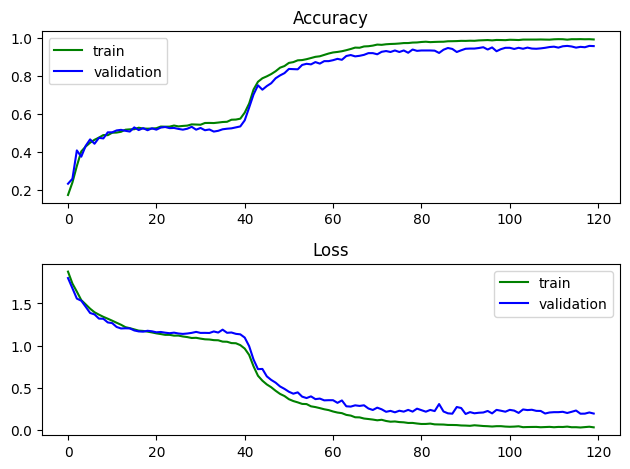

32/32 [==============================] - 1s 4ms/step


In [61]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest = np.argmax(Ytest, axis=1)

Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)
